In [1]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

In [2]:
# export
from decode_fish.imports import *

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.evaluation import *

from decode_fish.funcs.visualization import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

import h5py
from decode_fish.funcs.routines import *

initialize(config_path="../config")

hydra.initialize()

## Generate Data for comparison with ISTDECO

In [ ]:
cfg = OmegaConf.load(f'../config/experiment/sim_2d_1.yaml')

crop_sz = 128
cfg.training.bs = 10
cfg.sim.random_crop.crop_sz = crop_sz
cfg.data_path.image_sim.image_shape = [1,16,1,crop_sz,crop_sz]
_, decode_dl = get_dataloader(cfg)
_, noise, micro = load_psf_noise_micro(cfg)

In [ ]:
codebook, targets = hydra.utils.instantiate(cfg.codebook)

In [ ]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/'

densities = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2]
intensities = [1.]
# intensities = [0.8, 0.4, 0.2, 0.12]

In [ ]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *

gt_col = []
    
for d in densities:
    for i in intensities:

        k = f'dens_{d}_int_{i}'
        print(k)

        with h5py.File(out_dir+k+'.h5', 'w') as f:

            with torch.no_grad():

                ret_dict = next(iter(decode_dl))
                x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background']
                sim_vars = PointProcessUniform(local_rate[:,0]*0 + d, cfg.genm.intensity_dist.int_conc*i, cfg.genm.intensity_dist.int_rate, 
                                               cfg.genm.intensity_dist.int_loc, channels=16, n_bits=4, sim_z=False, codebook=torch.tensor(codebook), int_option=1).sample(from_code_book=True)
                ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1]))
                xsim = micro(*ch_inp)
                xsimn = micro.noise(xsim, background).sample()

                gt_vars = sim_vars[:-2]
                gt_df = sample_to_df(*gt_vars, sim_vars[-1], px_size_zyx=[1.,1.,1.])

            gt_df = px_to_nm(gt_df)
            gt_df = exclude_borders(gt_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

            add_df_to_hdf5(f, 'locations', gt_df)          
            f.create_dataset('frames', data=cpu(xsimn))

In [ ]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/'
files = glob.glob(out_dir+'/*.h5')
base_str = 'bsub -gpu "num=1" -q gpu_rtx -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_sim_eval.py '

with open('run_slurm.sh', 'w') as f:
    for n in files:
        name = n.split('/')[-1]
        print(name)
        f.write(base_str + f'data_file={name}' + ' \n')

In [ ]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/'
intensities = [1]
files = glob.glob(out_dir+'sim_2d_1/*')

with h5py.File(files[0], 'a') as f:
    print(f.keys())

In [ ]:
densities = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.2]
intensities = [1.0]

with h5py.File(files[0], 'r') as f:
    mod_keys = list(f.keys())

jacs = {k:np.zeros([len(intensities), len(densities)]) for k in mod_keys}

for f in files:
    with h5py.File(f, 'r') as h:
        for m in mod_keys:

            k = f.split('/')[-1].split('.h5')[0] 
            d = k.split('_')[1]
            i = k.split('_')[3]

            perf = get_df_from_hdf5(h[m]['perf'])
            
            if float(i) in intensities:
                jacs[m][intensities.index(float(i)),densities.index(float(d))] = perf['jaccard'].values[0]
            
            if k == 'dens_0.1_int_1.0':
                print(m)
                display(perf)

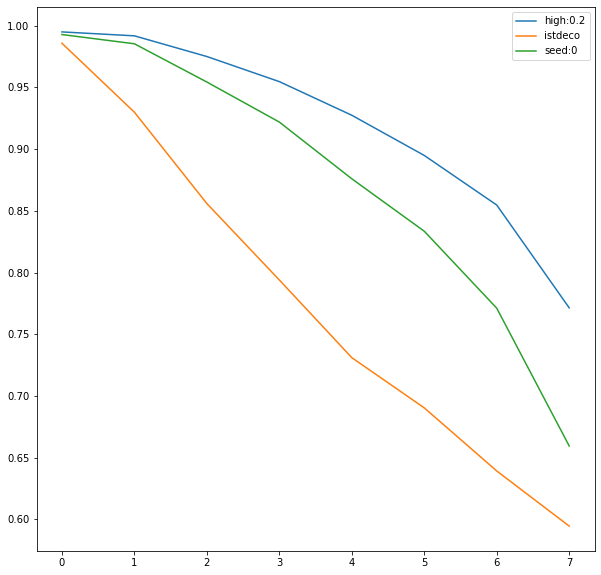

In [157]:
for i in range(len(intensities)):
    plt.figure(figsize=(10,10))
    for m in mod_keys:
        plt.plot(jacs[m][i], label=m)
    plt.legend()
    plt.show()

In [181]:
density = densities[3]
cfg = OmegaConf.load(f'../config/experiment/sim_2d_1.yaml')
codebook, targets = hydra.utils.instantiate(cfg.codebook)

with h5py.File(files[0], 'r') as f:
    mod_keys = list(f.keys())
    
with h5py.File(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/dens_{density}_int_1.0.h5', 'r') as f:

    gt_df = get_df_from_hdf5(f['locations'])

for f in [f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data4/sim_2d_1/dens_{density}_int_1.0.h5']:
    with h5py.File(f, 'r') as h:

        dec_df = get_df_from_hdf5(h['high:0.2']['locations'])
        ist_df = get_df_from_hdf5(h['istdeco']['locations_raw'])
        ist_df['loc_idx'] = np.arange(len(ist_df))
        
        perf, matches, _ = matching(gt_df, dec_df, tolerance=500, print_res=True, match_genes=True, allow_multiple_matches=False)
        dec_df.loc[:, 'class'] = 1
        dec_df.loc[dec_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0
        dec_df = sel_int_ch(dec_df, codebook)
        
        perf, matches, _ = matching(gt_df, ist_df, tolerance=500, print_res=True, match_genes=True, allow_multiple_matches=False)
        ist_df.loc[:, 'class'] = 1
        ist_df.loc[ist_df['loc_idx'].isin(matches['loc_idx_pred']), 'class'] = 0

Recall: 0.965
Precision: 0.989
Jaccard: 95.453
RMSE_vol: 11.458
Eff_3d: 92.686
FN: 369.0 FP: 111.0
Num. matches: 10077.000
Shift: 0.35,0.10,0.00
Recall: 0.978
Precision: 0.403
Jaccard: 39.964
RMSE_vol: 52.005
Eff_3d: 34.575
FN: 226.0 FP: 15127.0
Num. matches: 10220.000
Shift: -0.05,0.31,0.00


(0.0, 100.0)

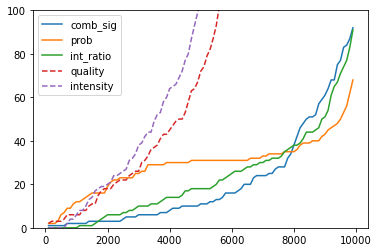

In [183]:
for k in ['comb_sig','prob','int_ratio']:
    b = False if k in ['tot_int','prob'] else True
    r  = make_roc(dec_df, k, n_max=10000, ascending=b)
    plt.plot(r[0],r[1], label=k)

# for k in ['quality','intensity']:
#     r  = make_roc(ist_df, k, n_max=10000, ascending=False)
#     plt.plot(r[0],r[1], label=k)

tra = ist_df[ist_df['intensity'] > 7000]
for k in ['quality','intensity']:
    r  = make_roc(tra, k, n_max=10000, ascending=False)
    plt.plot(r[0],r[1], label=k, linestyle='--')
    
plt.legend()
plt.ylim(0,100)